In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from evaluate import evaluate_holdout

In [2]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_coverage_data = pd.read_csv(f"{input_path}/scaled/coverage.csv")
encoded_coverage_data  = pd.read_csv(f"{input_path}/encoded/coverage.csv")
catboost_coverage_data = pd.read_csv(f"{input_path}/catboost/coverage.csv")

In [3]:
# Разделение признаков и целевой переменной
X_scaled = scaled_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_scaled = scaled_coverage_data["experiment.results.coverage.value"]

X_encoded  = encoded_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_encoded  = encoded_coverage_data["experiment.results.coverage.value"]

X_catboost = catboost_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_catboost = catboost_coverage_data["experiment.results.coverage.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

In [ ]:
# Достаём scale  и mean для обратного преобразования
df = pd.read_csv(f"{input_path}/scaled/full.csv")
column_name = "experiment.results.coverage.value"
column_index = df.columns.get_loc(column_name)

scaler = joblib.load(f"{input_path}/scaled/std_scaler.joblib")
scale = scaler.scale_[column_index]
mean = scaler.mean_[column_index]

In [5]:
# Разделение данных на тренеровочную и тестовую выборки
TEST_SIZE = 0.2

X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
    X_scaled, y_scaled, test_size = TEST_SIZE, random_state = 0 
)

X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(
    X_encoded, y_encoded, test_size = TEST_SIZE, random_state = 0 
)

X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(
    X_catboost, y_catboost, test_size = TEST_SIZE, random_state = 0 
)

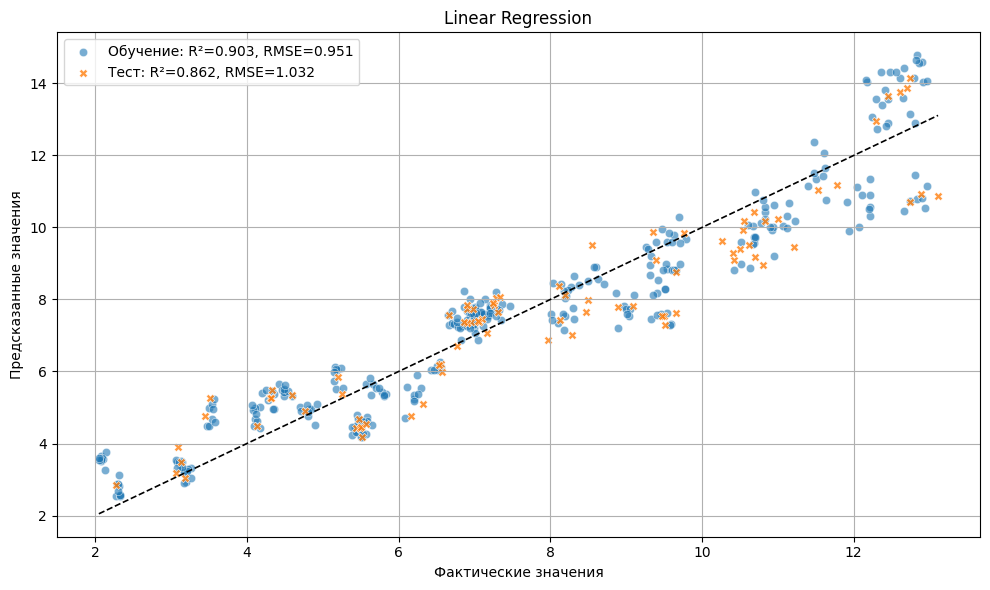

In [6]:
results["LinearRegression"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test, 
    LinearRegression(), "Linear Regression",
    scale=scale, mean=mean
)

In [7]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': np.float64(10.0), 'epsilon': np.float64(0.1), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9610360700826319


In [8]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(0, 2, 40),        
    'epsilon': np.logspace(-2, 0, 40),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
Best parameters: {'C': np.float64(9.426684551178852), 'epsilon': np.float64(0.10608183551394483), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9598233303697297


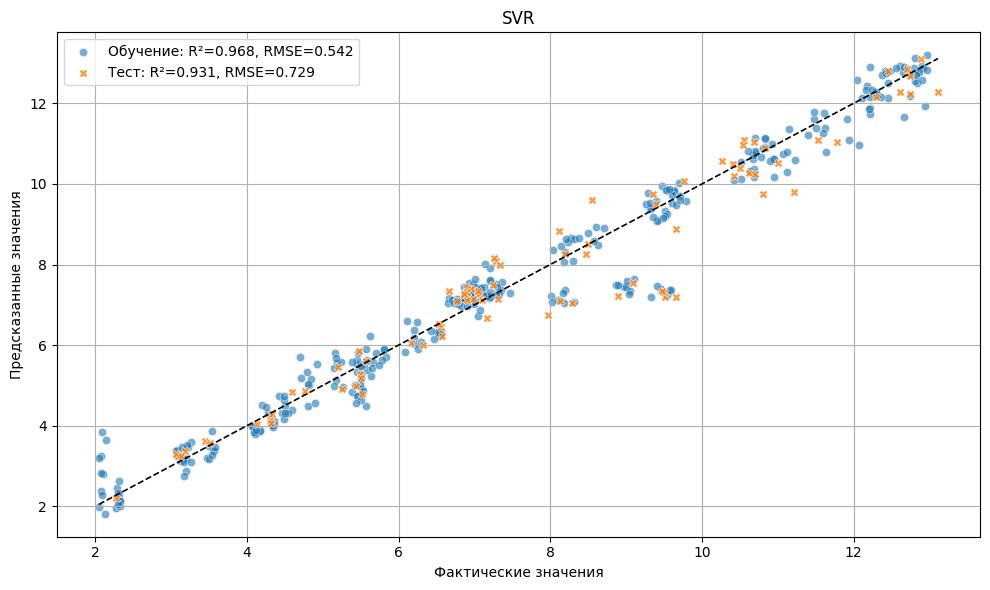

In [9]:
results["SVR"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test,
    SVR(**grid_search.best_params_), "SVR",
    scale=scale, mean=mean
)

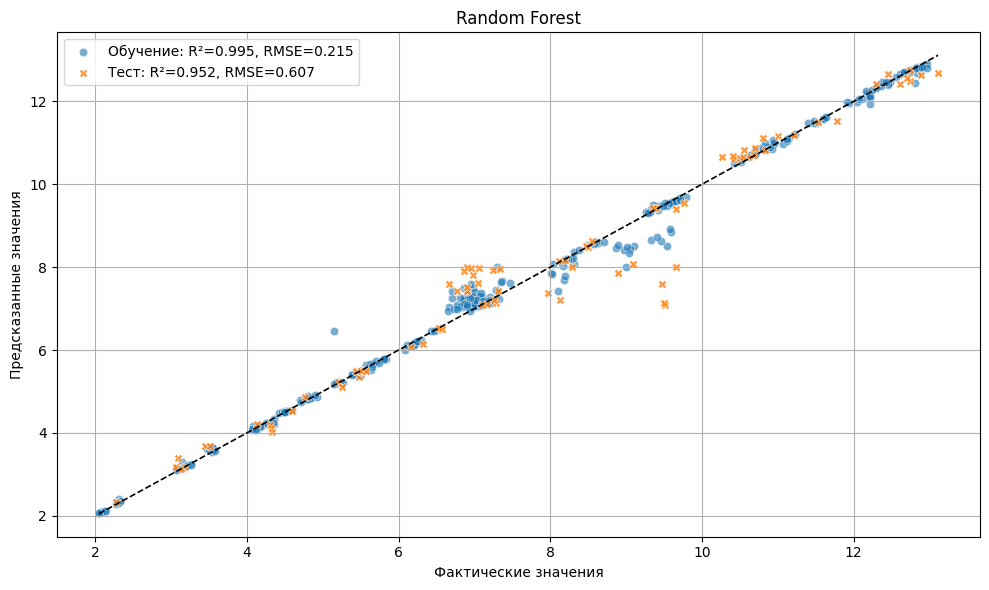

In [10]:
results["RandomForest"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    RandomForestRegressor(), "Random Forest"
)

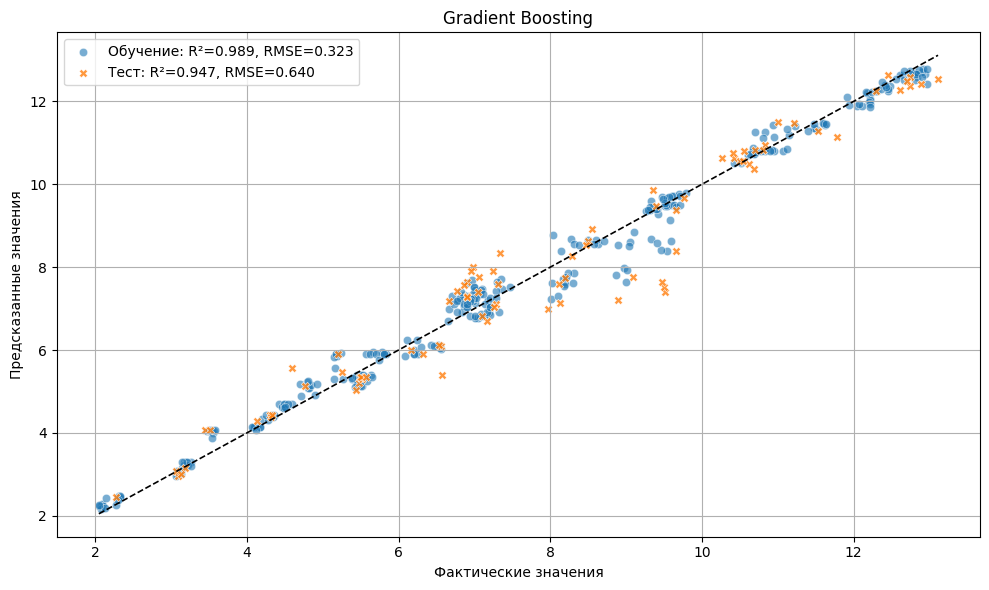

In [11]:
results["GradientBoosting"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    GradientBoostingRegressor(), "Gradient Boosting"
)

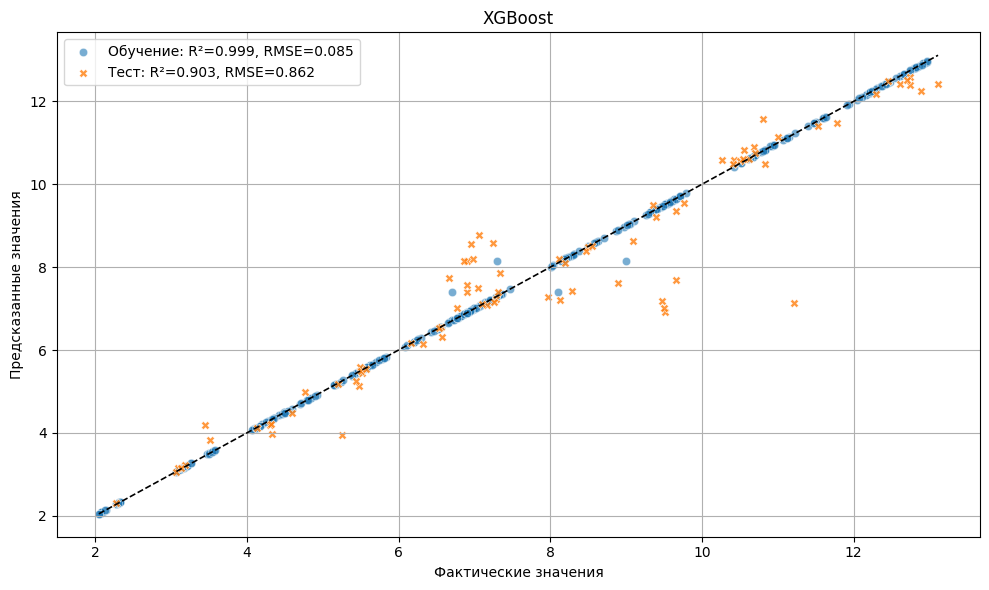

In [12]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(), "XGBoost"
)

In [13]:
# Параметры для подбора XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'subsample': Continuous(0.5, 1.0),
    'colsample_bytree': Continuous(0.5, 1.0),
    'gamma': Continuous(0, 5),
    'reg_alpha': Continuous(0, 2),
    'reg_lambda': Continuous(0, 2),
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Генетический поиск
evolved_search = GASearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=0),
    cv=cv,
    scoring='r2',
    param_grid=param_grid,
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

# Обучение
evolved_search.fit(X_encoded_train, y_encoded_train)

# Лучшие параметры
print("Best parameters:", evolved_search.best_params_)
print("Best R2 score (CV):", evolved_search.best_score_)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.911463	0.0427162  	0.940687   	0.692068   
1  	60    	0.92831 	0.009528   	0.941559   	0.901048   
2  	60    	0.936972	0.00458354 	0.941559   	0.926515   
3  	60    	0.939581	0.00246811 	0.943806   	0.930571   
4  	60    	0.940393	0.00226288 	0.943085   	0.930731   
5  	60    	0.941921	0.00134858 	0.945665   	0.939602   
6  	60    	0.943098	0.00182897 	0.948251   	0.940278   
7  	60    	0.943753	0.00133926 	0.947628   	0.942158   
8  	60    	0.943679	0.00302958 	0.948479   	0.930296   
9  	60    	0.944277	0.00356247 	0.948479   	0.92749    
10 	60    	0.94641 	0.0016382  	0.948867   	0.943085   
11 	60    	0.946794	0.00284415 	0.948867   	0.932322   
12 	60    	0.948102	0.000751574	0.949635   	0.946444   
13 	60    	0.948578	0.000951187	0.950061   	0.944894   
14 	60    	0.948786	0.000764324	0.950061   	0.946855   
15 	60    	0.948824	0.000629831	0.950061   	0.947479   
16 	60    	0.949046	0.000695999	0.950061   	0.94

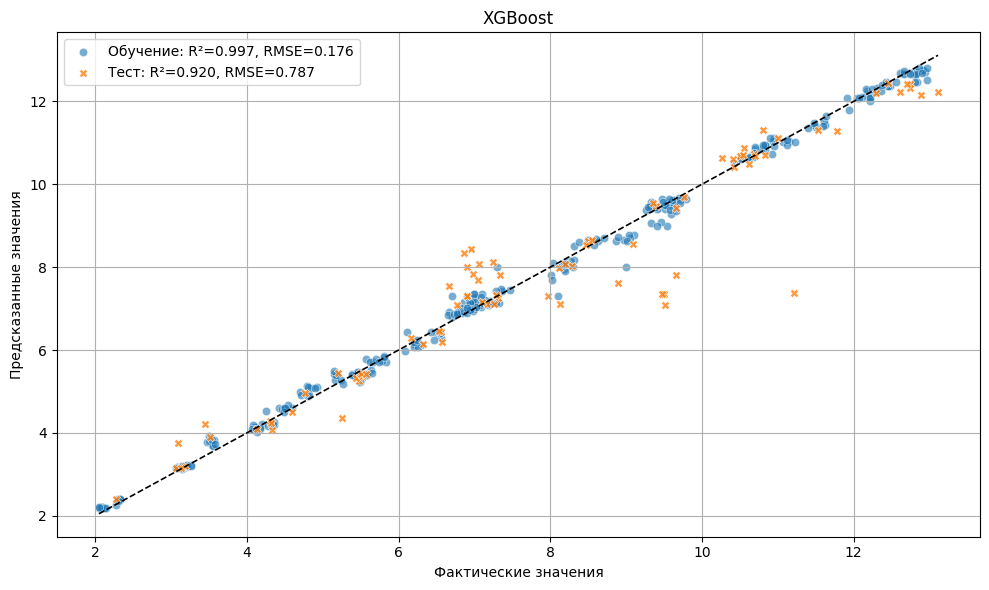

In [14]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(**evolved_search.best_params_), "XGBoost"
)

Learning rate set to 0.034462
0:	learn: 2.9803028	total: 145ms	remaining: 2m 24s
1:	learn: 2.8995433	total: 198ms	remaining: 1m 38s
2:	learn: 2.8271472	total: 230ms	remaining: 1m 16s
3:	learn: 2.7559004	total: 381ms	remaining: 1m 34s
4:	learn: 2.6954411	total: 486ms	remaining: 1m 36s
5:	learn: 2.6386764	total: 531ms	remaining: 1m 27s
6:	learn: 2.5679626	total: 623ms	remaining: 1m 28s
7:	learn: 2.5085324	total: 677ms	remaining: 1m 23s
8:	learn: 2.4591905	total: 740ms	remaining: 1m 21s
9:	learn: 2.3973839	total: 792ms	remaining: 1m 18s
10:	learn: 2.3441218	total: 860ms	remaining: 1m 17s
11:	learn: 2.2945759	total: 928ms	remaining: 1m 16s
12:	learn: 2.2458721	total: 985ms	remaining: 1m 14s
13:	learn: 2.1911042	total: 1.04s	remaining: 1m 13s
14:	learn: 2.1506062	total: 1.09s	remaining: 1m 11s
15:	learn: 2.1007734	total: 1.14s	remaining: 1m 10s
16:	learn: 2.0557954	total: 1.19s	remaining: 1m 8s
17:	learn: 2.0109898	total: 1.24s	remaining: 1m 7s
18:	learn: 1.9775075	total: 1.3s	remaining: 1m

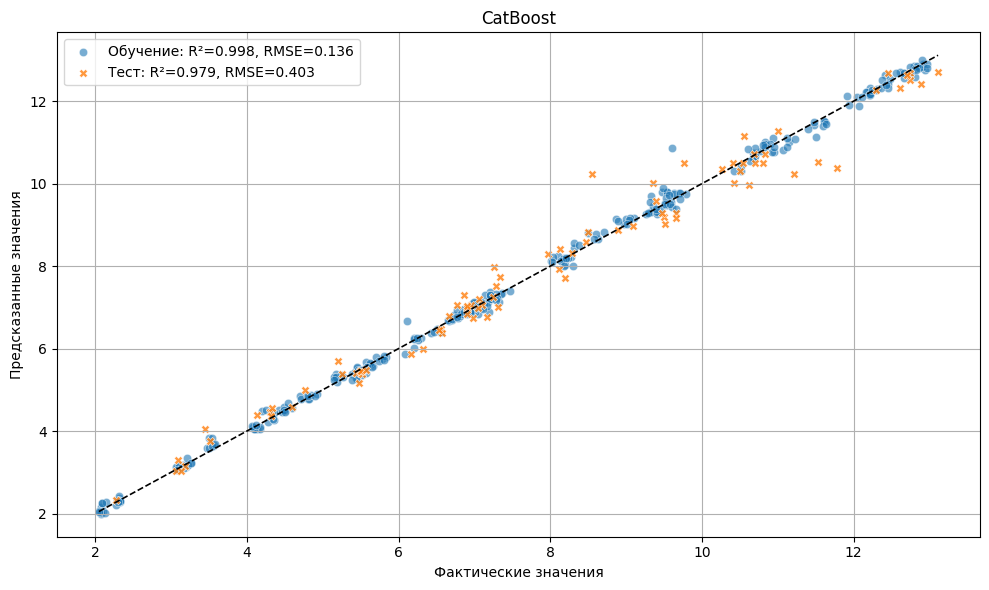

In [15]:
results["CatBoost"] = evaluate_holdout(
    X_catboost_train, X_catboost_test,
    y_catboost_train, y_catboost_test, 
    CatBoostRegressor(), "CatBoost",
    cat_features=catboost_features
)

In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.T.reset_index().rename(columns={'index': 'Модель'})
results_df = results_df.sort_values("r2_test", ascending=False).reset_index(drop=True)
results_df = results_df.rename(columns={
    "model":      "Модель",
    "r2_train":   "R² обуч.",
    "rmse_train": "RMSE обуч.",
    "r2_test":    "R² тест.",
    "rmse_test":  "RMSE тест."
})

results_df

,Модель,R² обуч.,RMSE обуч.,R² тест.,RMSE тест.
0,CatBoost,0.998025,0.135801,0.978861,0.403143
1,RandomForest,0.995028,0.215485,0.952139,0.606611
2,GradientBoosting,0.988823,0.323084,0.946735,0.639943
3,SVR,0.968489,0.542478,0.930807,0.729373
4,XGBoost,0.996682,0.176043,0.919520,0.786617
5,LinearRegression,0.903087,0.951350,0.861556,1.031707
